In [1]:
import os, cv2, geojson
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import cm, colors
from pyproj import Proj
UTM_10_PROJ = Proj("+proj=utm +zone=10N, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [2]:
def stddev_above_threshold(x,y,window_size, threshold,im):
    r = im[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size, 0:3]
    return r.std() > threshold
def compressed_green(x,y,window_size,green_mask):
    r = green_mask[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size]
    return r.mean() > 128
def convert_to_lon_lat(polygon_10_m, utm_10_bot_left_coord):
    polygon_10_m = polygon_10_m/ 10
    polygon_10_m = [[x[0][0]+utm_10_bot_left_coord[0],1000-x[0][1]+utm_10_bot_left_coord[1]] for x in polygon_10_m]
    projected = [UTM_10_PROJ(x[0], x[1], inverse=True) for x in polygon_10_m]
    head = projected[0]
    projected.append(head)
    return projected

In [3]:
os.chdir("/home/jonathan/ubc/capstone/orthophoto/2014")
image = cv2.imread('483E_5454N.tif')

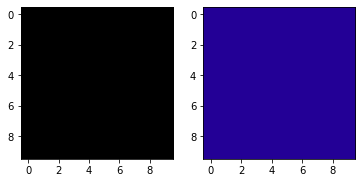

In [4]:
dark_green = (55/360*255,0, 0)
light_green = (180/360*255, 255, 150)
lo_square = np.full((10, 10, 3), light_green, dtype=np.uint8)
do_square = np.full((10, 10, 3), dark_green, dtype=np.uint8)
plt.subplot(1, 2, 1)
lo_square = cv2.cvtColor(lo_square, cv2.COLOR_HSV2RGB)
do_square = cv2.cvtColor(do_square, cv2.COLOR_HSV2RGB)
plt.imshow(do_square)
plt.subplot(1, 2, 2)
plt.imshow(lo_square)
plt.show()

In [5]:
kernel = np.ones((20,20),np.float32)/400
blurred_image = cv2.filter2D(image,-1,kernel)
hsv_blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_blurred_image, dark_green, light_green)

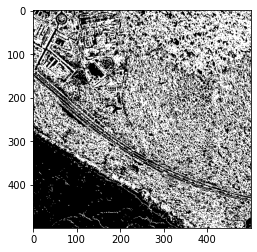

In [6]:
blurred_image = ndimage.gaussian_filter(image, sigma=2)
n = 500
stddev_array = np.array([stddev_above_threshold(i//n,i%n,20,12,blurred_image) for i in range(0,n**2)]).reshape(n,n)
plt.imshow(stddev_array, cmap=plt.cm.gray)

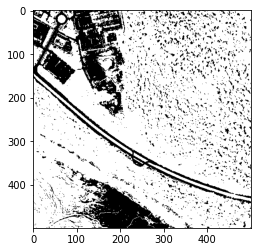

In [7]:
n = 500 
compressed_green_array = np.array([compressed_green(i//n,i%n,20,mask) for i in range(0,n**2)]).reshape(n,n)
plt.imshow(compressed_green_array, cmap=plt.cm.gray)

In [8]:
n=500
green_stddev_array = np.array([compressed_green_array[i//n,i%n] and stddev_array[i//n,i%n] for i in range(0,n**2)]).reshape(n,n)
close_img = ndimage.binary_closing(green_stddev_array)
open_img = ndimage.binary_opening(close_img)
plt.imsave("green_stddev.png", open_img)

In [9]:
im = cv2.imread('green_stddev.png')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

169

In [10]:
lon_lat = convert_to_lon_lat(contours[0]*20,[483000,5454000])

In [11]:
feature_list = []
for c in contours:
    lon_lat = convert_to_lon_lat(c*20,[483000,5454000])
    feature_list.append(geojson.Feature(geometry=geojson.Polygon([lon_lat])))
feature_collection = geojson.FeatureCollection(feature_list)

with open("polygons2.geojson", mode = "w") as out_file:
    geojson.dump(feature_collection,out_file)